In [1]:
import numpy as np
from matplotlib import pyplot as plt

from warper import simulate_2d_only_memory, simulate_2d_only_memory_anharmonic_2

from multiprocessing import Pool

import os, pickle
from tqdm.notebook import tqdm

import pandas as pd


from nsdesolve import Uxy_2

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams["figure.facecolor"] = "white"

In [3]:
pool = Pool(4)

In [4]:
def get_cov(R,S,H):
    Z = np.zeros(len(R))
    return np.array([[R,Z,Z,H],
                     [Z,R,-H,Z],
                     [Z,-H,S,Z],
                     [H,Z,Z,S]])

def omega_kumulant(A,B,g0,ka):
    bigO=A + 2*B/ka**2/g0
    
    op2 = 1/2 * (bigO+abs(bigO)*np.sqrt(1+8*B/g0/bigO**2))
    om2 = 1/2 * (bigO-abs(bigO)*np.sqrt(1+8*B/g0/bigO**2))
    return op2, om2
 
def get_RSH(o0,g0,b,ka):
    mu = ka
    S = 1/g0/2/ka**2*(ka**2+o0**2+g0*ka+b**2)
    R = 1/g0/2/o0**2/ka**2 * (o0**2+ka**2)
    H = - 1/2/g0/ka**2*b
    
    return R,S,H, 2*(R*S+H**2)

def mean_with_err(arr, axis):
    return arr.mean(axis=axis), arr.std(axis=axis)/np.sqrt(arr.shape[axis])

In [5]:
# params - A,B,C,D,F,g0,b,ka

params = [
]

bs =  np.array([0,0.5,1,2,3,4,8,14,22,28])/10

params += [dict(A=-3.,B=0.05,C=0.,D=0.,F=0.,g0=0.3,b=b,ka=1.) for b in bs]
params += [dict(A=-2,B=0.05,C=0,D=0,F=0,g0=0.3,b=b,ka=1) for b in bs]
params += [dict(A=-1,B=0.05,C=0,D=0,F=0,g0=0.3,b=b,ka=1) for b in bs]
params += [dict(A=0,B=0.05,C=0,D=0,F=0,g0=0.3,b=b,ka=1) for b in bs]
params += [dict(A=1,B=0.05,C=0,D=0,F=0,g0=0.3,b=b,ka=1) for b in bs]
params += [dict(A=2,B=0.05,C=0,D=0,F=0,g0=0.3,b=b,ka=1) for b in bs]

df = pd.DataFrame(params, columns=["A","B","C","D","F","g0","b","ka"])

df["O+^2"],df["O-^2"] = omega_kumulant(df.A, df.B, df.g0, df.ka)

df["R"],df["S"],df["H"],df["varL"]=get_RSH(np.sqrt(df["O+^2"]),df.g0,df.b,df.ka)

In [6]:
(bs_expected, R_expected, S_expected, H_expected
) = np.array([((b,)+ get_RSH(1,g0=0.3,b=b,ka=1)[:3] )
              for b in np.linspace(min(bs), max(bs))]).T

In [7]:
df["S_init"] = df["S"]
df["R_init"] = df.R

df["H_init"] = df.H

In [214]:
df["S_init"] = df.Sx
df["R_init"] = df.Rx
df["H_init"] = df.Hx

In [8]:
df.head()

,A,B,C,D,F,g0,b,ka,O+^2,O-^2,R,S,H,varL,S_init,R_init,H_init
0,-3.0,0.05,0.0,0.0,0.0,0.3,0.00,1.0,0.119633,-2.7863,15.598165,2.366055,-0.000000,73.812231,2.366055,15.598165,-0.000000
1,-3.0,0.05,0.0,0.0,0.0,0.3,0.05,1.0,0.119633,-2.7863,15.598165,2.370222,-0.083333,73.956105,2.370222,15.598165,-0.083333
2,-3.0,0.05,0.0,0.0,0.0,0.3,0.10,1.0,0.119633,-2.7863,15.598165,2.382722,-0.166667,74.387726,2.382722,15.598165,-0.166667
3,-3.0,0.05,0.0,0.0,0.0,0.3,0.20,1.0,0.119633,-2.7863,15.598165,2.432722,-0.333333,76.114209,2.432722,15.598165,-0.333333
4,-3.0,0.05,0.0,0.0,0.0,0.3,0.30,1.0,0.119633,-2.7863,15.598165,2.516055,-0.500000,78.991681,2.516055,15.598165,-0.500000


In [9]:
N=2000000
warmup=0
dt=0.001
samples=400
skip=1000
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

dump_to_disk = False

In [10]:
(len(df) * N * runs * samples *4 // skip) * 4 / 1024**3

2.86102294921875

In [12]:
get_cov(df.R_init, df.S_init, df.H_init).shape

(4, 4, 60)

In [13]:
results = []
sigmas = get_cov(df.R_init, df.S_init, df.H_init).transpose(2,0,1)

In [14]:
for row, sigma in tqdm(zip(df.itertuples(),sigmas), total=len(df)):
#     if row.Index <40:
#         continue
    x0,y0,vx0,vy0 = np.random.multivariate_normal([0,0,0,0], sigma, samples).T
    kwargs = dict(x0=x0,y0=y0,vx0=vx0,vy0=vy0,
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        A=-row.A,B=row.B,C=row.C,D=row.D,F=row.F,
        gamma0=row.g0,b=row.b, kappa=row.ka)
    res = simulate_2d_only_memory_anharmonic_2(pool,runs,**kwargs)
    if dump_to_disk:
        np.save(f"results/{row.Index}", res)
    else:
        results.append(np.array(res[:], dtype="float32"))

In [78]:
results = np.array(results); results.shape

KeyboardInterrupt: 

### Load dumped data

In [79]:
results.shape

(60, 6, 1600, 2000)

In [80]:
np.save("results", results)

In [9]:
results = np.load("results.npy")

In [ ]:
import os
n_files = len(os.listdir("results"))

In [ ]:
np.load("results/1.npy").shape

In [ ]:
results = np.zeros((n_files, 4, 800, 5000))

In [ ]:
for i in tqdm(range(n_files)):
    results[i] = np.load(f"results/{i}.npy")[:4,:,-5000:]

In [ ]:
results[:,:,:,:].shape

### Start Analisys

In [10]:
cov_all = np.einsum("iakj,ibkj->ijab", results[:,:4,:,:],results[:,:4,:,:],optimize=True)/(results.shape[2]-1)
cov = cov_all
# cov = cov[df[df.b].index]

In [11]:
cov = cov_all[:,:100]
cov.shape

(60, 100, 4, 4)

In [12]:
sp = 1
cov_R = cov[:,::sp,(0,1),(0,1)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_S = cov[:,::sp,(2,3),(2,3)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_H = cov[:,::sp,(0,1,2,3),(3,2,1,0)].transpose(1,0,2).reshape(-1, cov.shape[0]*4)
cov_Z = cov[:,::sp,(0,0,1,1,2,2,3,3),(1,2,0,3,0,3,1,2)].transpose(1,0,2).reshape(-1, cov.shape[0]*8)

In [13]:
del cov_all

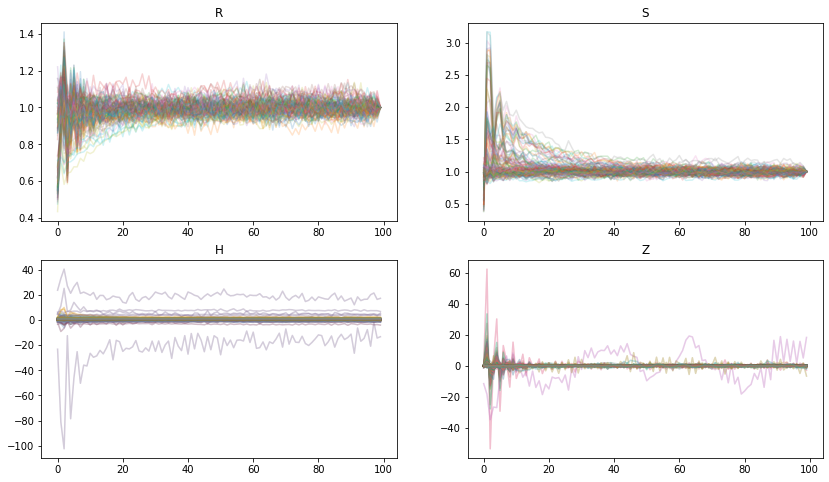

In [14]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(cov_R/cov_R[-1], alpha=0.2);plt.title("R")
plt.subplot(2,2,2)
plt.plot(cov_S/cov_S[-1], alpha=0.2);plt.title("S")
plt.subplot(2,2,3)
plt.plot(cov_H/(1+cov_H[-1]), alpha=0.2);plt.title("H")
plt.subplot(2,2,4)
plt.plot(cov_Z/(1+cov_Z[-1]), alpha=0.2);plt.title("Z");

In [15]:
stationari_treshold = 500

In [16]:
results.shape

(60, 6, 1600, 2000)

In [17]:
res = results[...,stationari_treshold::1]
Rx,Ry, Sx, Sy,_,_= res[...,::3].var(axis=2).transpose(1,0,2)
Lx = res[:,0] * res[:,3]
Ly = res[:,1] * res[:,2]

Hx = Lx.mean(axis=1)
Hy = Ly.mean(axis=1)

In [18]:
df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)
df["Ry"], df["Ry_err"]= mean_with_err(Ry,axis=-1)
df["Sx"], df["Sx_err"]= mean_with_err(Sx,axis=-1)
df["Sy"], df["Sy_err"]= mean_with_err(Sy,axis=-1)
df["Hx"], df["Hx_err"]= mean_with_err(Hx,axis=-1)
df["Hy"], df["Hy_err"]= mean_with_err(Hy,axis=-1)

# df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)


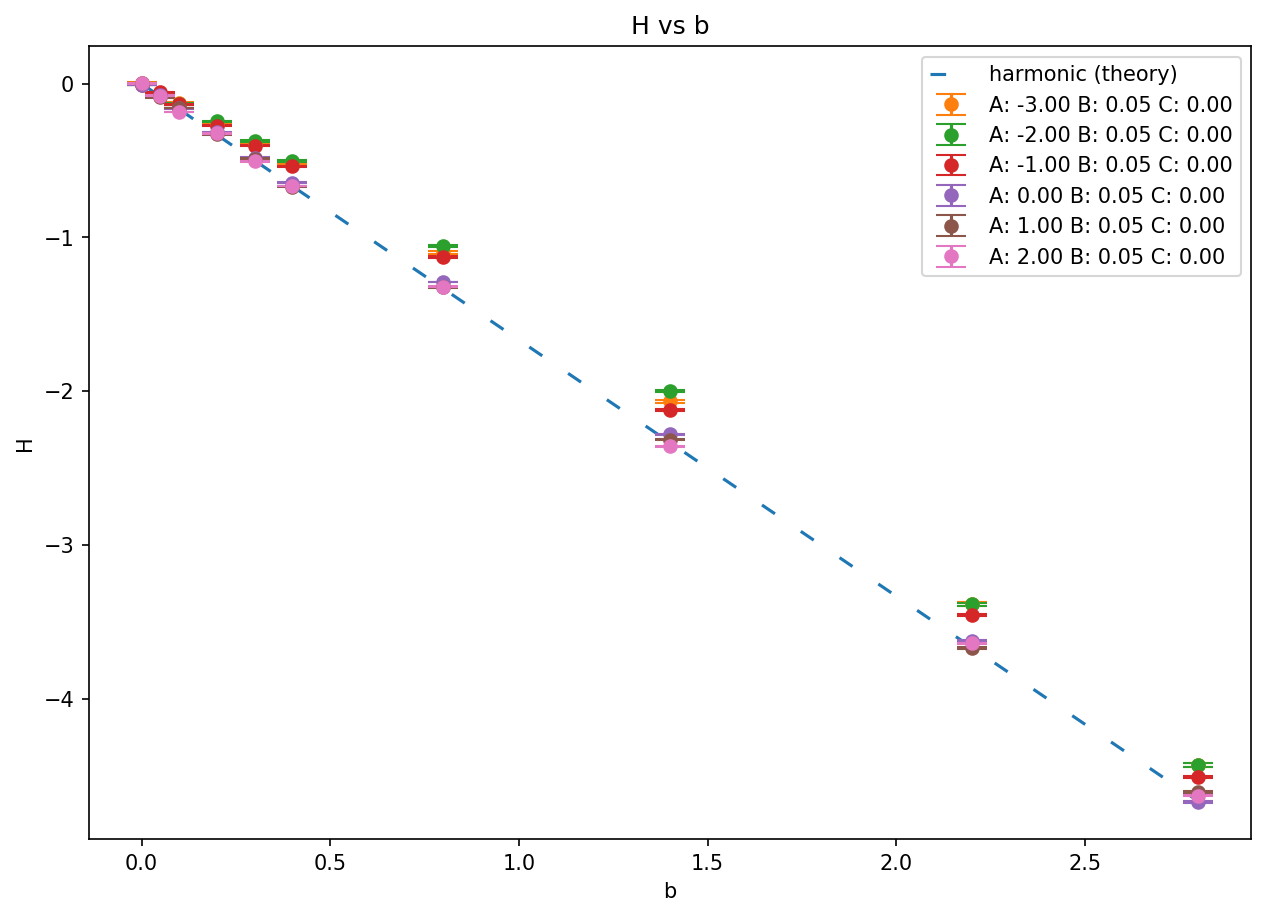

In [19]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.title("H vs b")
plt.xlabel("b");plt.ylabel("H")
plt.plot(bs_expected, H_expected,ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Hx, yerr=gp.Hx_err, capsize=7, marker="o", ls="none", 
                 label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

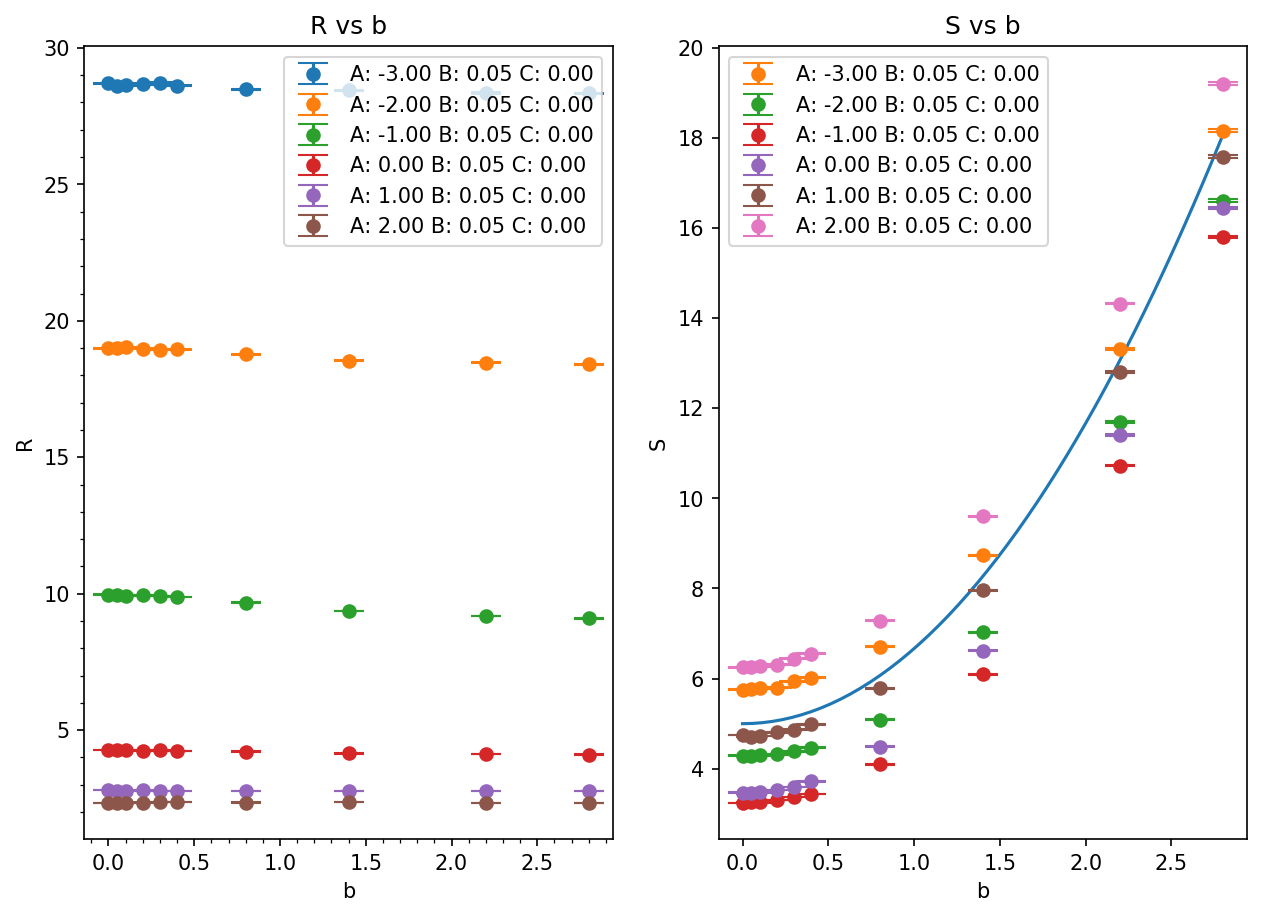

In [20]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.subplot(121)
plt.title("R vs b")
plt.xlabel("b");plt.ylabel("R")
# plt.plot(*zip(*[(b, get_RSH(-7, 0,100,b,10)[0]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Rx, yerr=gp.Rx_err, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.minorticks_on()
plt.legend()

plt.subplot(122)
plt.title("S vs b")
plt.xlabel("b");plt.ylabel("S")
plt.plot(bs_expected, bs_expected**2/2/0.3+5)
# plt.plot(*zip(*[(b, get_RSH(-7, 0,100,b,10)[1]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Sx, yerr=gp.Sx_err, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.legend()

## xry analysis

In [47]:
res = results[...,stationari_treshold::]

uxs, uys = [], []
for row in df.itertuples():
    ux, uy = Uxy_2(row.A, row.B, row.C, row.D, row.F, res[row.Index,0].flatten(),res[row.Index,1].flatten() )
    uxs.append(ux.reshape(res.shape[2], res.shape[3]))
    uys.append(uy.reshape(res.shape[2], res.shape[3]))

uxs=np.array(uxs)
uys=np.array(uys)

xry= res[:,0] * res[:,5]
yrx= res[:,1] * res[:,4]

uxry= uxs*res[:,5]
uyrx= uys*res[:,4]

In [50]:
xry.shape

(60, 1600, 1500)

In [51]:
df["xry"], df["xry_err"]=mean_with_err(xry.reshape(xry.shape[0],-1), axis=1)
df["uxry"], df["uxry_err"]=mean_with_err(uxry.reshape(uxry.shape[0],-1), axis=1)

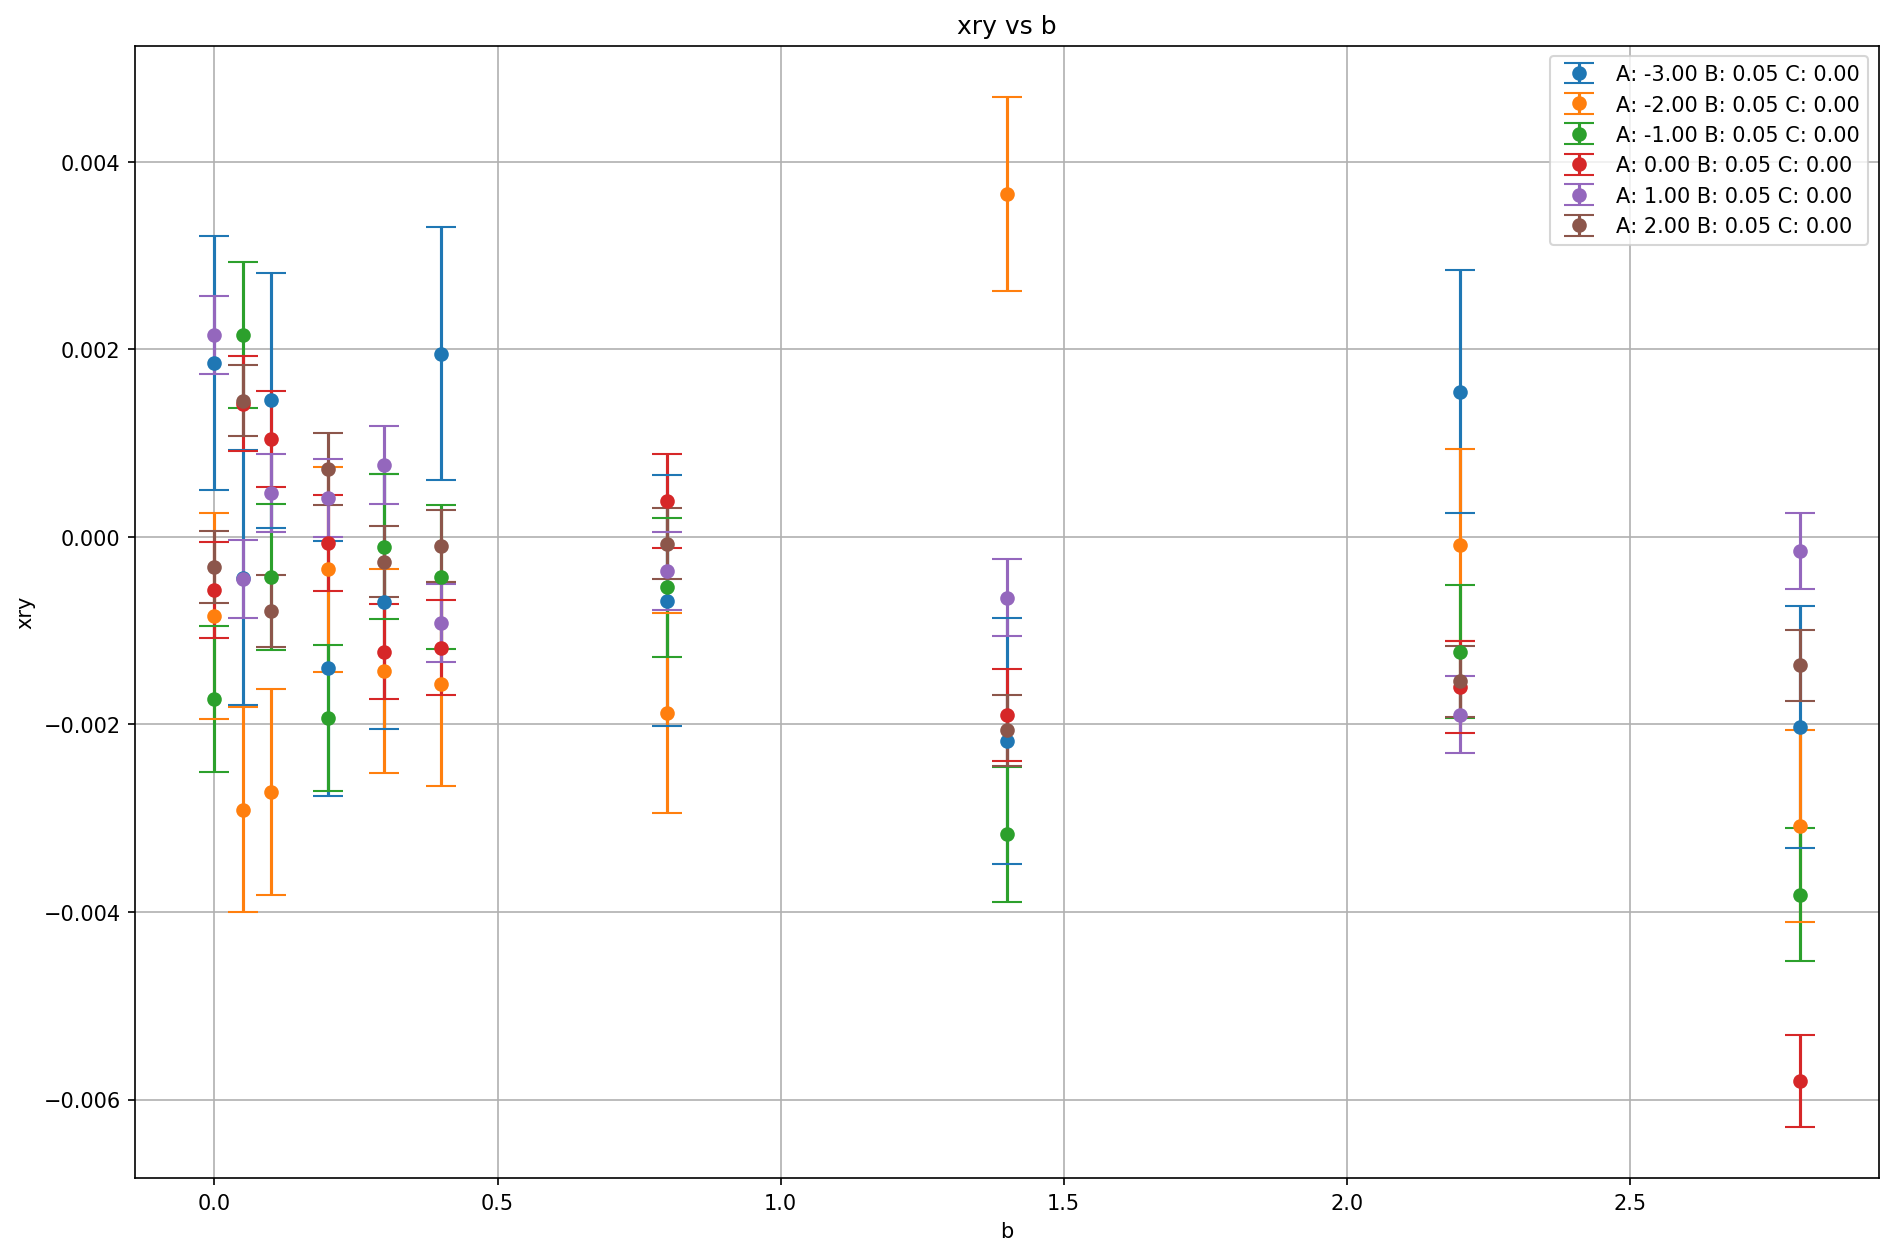

In [58]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(15,10), dpi=150)
plt.title("xry vs b")
plt.xlabel("b");plt.ylabel("xry")
# plt.plot(bs_expected, H_expected,ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.xry, yerr=gp.xry_err, capsize=7, marker="o", ls="none", 
                 label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.grid()
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

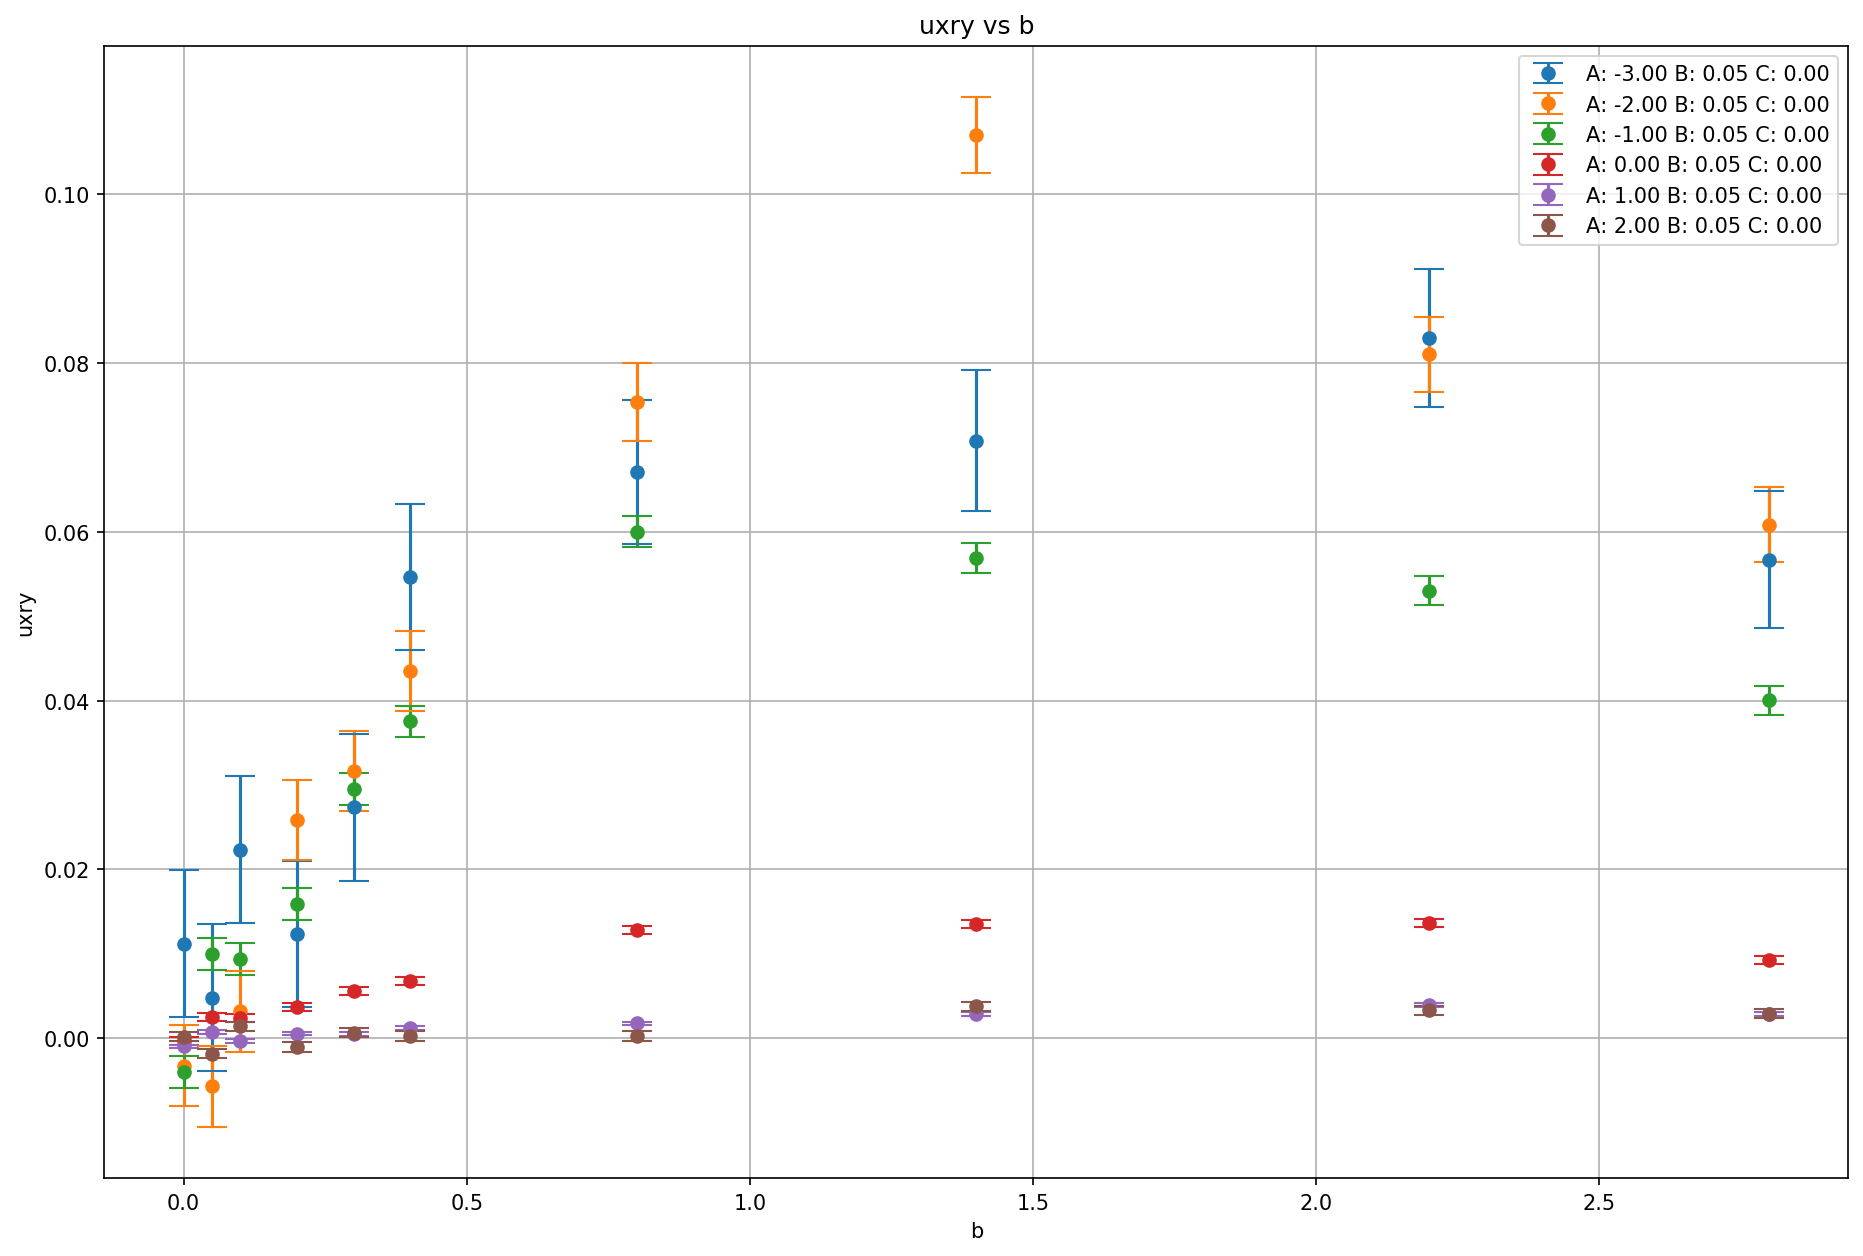

In [59]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(15,10), dpi=150)
plt.title("uxry vs b")
plt.xlabel("b");plt.ylabel("uxry")
# plt.plot(bs_expected, H_expected,ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.uxry, yerr=gp.uxry_err, capsize=7, marker="o", ls="none", 
                 label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.grid()
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

In [78]:
gp.g0.mean() * gp.ka.mean()**2

0.29999999999999993

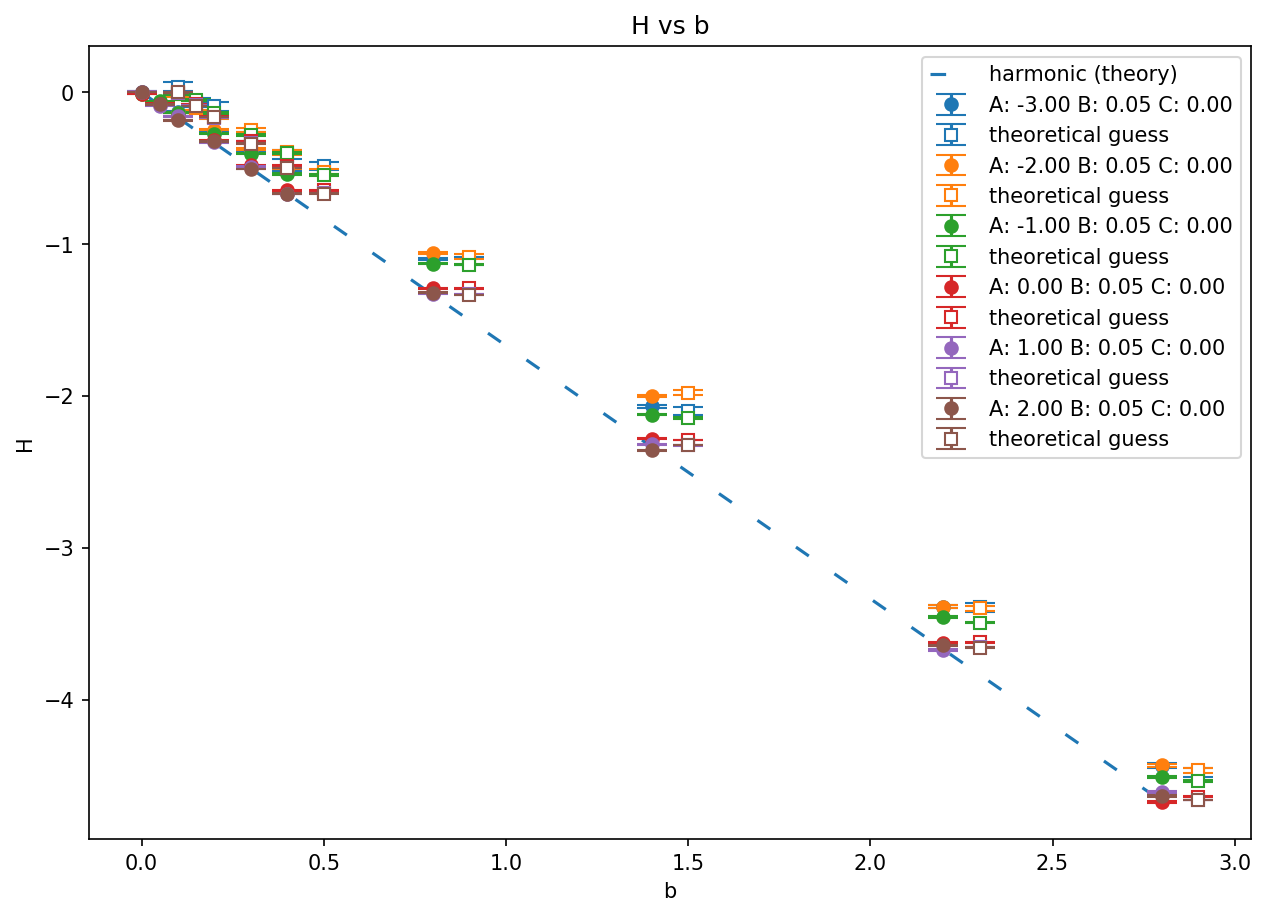

In [81]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.title("H vs b")
plt.xlabel("b");plt.ylabel("H")
plt.plot(bs_expected, H_expected,ls=(0, (5, 10)), label="harmonic (theory)")
for ii, key in enumerate(gb.groups):
    
    gp = gb.get_group(key)
    
    g0kasq=gp.g0.mean() * gp.ka.mean()**2
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Hx, yerr=gp.Hx_err, capsize=7, marker="o",color=COLORS[ii], ls="none", 
                 label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
    
    plt.errorbar(gp.b+0.1, gp.H + gp.uxry/g0kasq, yerr=gp.uxry_err/g0kasq, capsize=7,color=COLORS[ii], marker="s", mfc="white", ls="none", 
                 label=f"theoretical guess")
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

In [ ]:
plt.plot(xry)